```
From: https://github.com/ksatola
Version: 0.1.0
```

# Model - PM2.5 - AutoRegressive Integrated Moving Average (ARIMA)

## Contents

- [AutoRegressive Integrated Moving Average (ARIMA) modelling](#base)
- [Difference Between an ARMA Model and ARIMA (ARIMAX, SARIMAX)](#diff)
- Hourly forecast
    - [Load hourly data](#data_h)
    - [Modelling (train, predict/validate)](#model_h)
- Daily forecast
    - [Load daily data](#data_d)
    - [Modelling](#model_d)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../src')

In [4]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)

In [5]:
import pandas as pd 
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
from model import (
    get_pm25_data_for_modelling,
    get_best_arima_params_for_time_series,
    split_df_for_ts_modelling_offset,
    predict_ts,
    fit_model
)

from measure import (
    get_rmse,
    walk_forward_ts_model_validation2,
    get_mean_folds_rmse_for_n_prediction_points,
    prepare_data_for_visualization
)

from plot import (
    visualize_results,
    plot_ts_corr
)

from utils import (
    get_datetime_identifier
)

from logger import logger

In [7]:
model_name = 'ARIMA'

---
<a id='base'></a>

## AutoRegressive Integrated Moving Average (ARIMA) modelling

AutoRegressive Integrated Moving Average (ARIMA) modeling (or Box-Jenkins modeling), is an approach to modeling ARIMA processes — mathematical models used for forecasting. The approach uses previous time series data plus an error to forecast future values. ARIMA combines a general autoregressive model AR(p) and general moving average model MA(q):
```
AR(p) uses previous values of the dependent variable to make predictions.
MA(q) uses the series mean and previous errors to make predictions.
```
The approach was first proposed by Box and Jenkins (1970), who detailed ARIMA’s estimation and prediction procedures.

### Notation
Nonseasonal Autoregressive Integrated Moving Average models are classified by three factors:
```
p = number of autoregressive terms,
d = how many nonseasonal differences are needed to achieve stationarity,
q = number of lagged forecast errors in the prediction equation.
```
For example, an ARIMA(1,0,2) has 1 autoregressive term, no needed differences for stationarity and 2 lagged forecast errors.

### Steps
The basic steps of the Box and Jenkins are:

1. Prepare your data by using transformations (i.e. square roots or logarithms) to stabilize the variance and differencing to remove remaining seasonality or other trends.
2. Identify any processes that appear to be a good fit for your data.
3. Find which model coefficients provide the best fit for your data. This step is computationally complex and usually performed by a computer. Akaike’s Information Criterion (AIC) is one option: if you compare two models, the one with the lower AIC is usually the “better” model.
4. Test the models’ assumptions to see how well the model holds up to closer scrutiny. If your chosen model is inadequate, repeat steps 2 and 3 to find a potentially better model.
5. Compute forecasts on your chosen model with computer software.

---
<a id='diff'></a>

## Difference Between an ARMA Model and ARIMA

The two models share many similarities. In fact, the AR and MA components are identical, combining a general autoregressive model AR(p) and general moving average model MA(q). AR(p) makes predictions using previous values of the dependent variable. MA(q) makes predictions using the series mean and previous errors.

What sets ARMA and ARIMA apart is **differencing**. An `ARMA model is a stationary model`; If your model isn’t stationary, then you can achieve stationarity by taking a series of differences. The “I” in the ARIMA model stands for integrated; It is a measure of how many nonseasonal differences are needed to achieve stationarity. If no differencing is involved in the model, then it becomes simply an ARMA.

A model with a dth difference to fit and ARMA(p,q) model is called an `ARIMA process of order (p,d,q)`. You can select p,d, and q with a wide range of methods, including AIC, BIC, and empirical autocorrelations.

`ARMA` models work on the assumption of stationarity (i.e. they must have a constant variance and mean). If your model is non-stationary, you’ll need to transform it before you can use ARMA.

`ARIMA` can be used for non-stationary series, that is, where the data do not fluctuate around the same mean, variance and co-variance. This family of models can identify trend and seasonality as part of the fitting process.

Another, similar model is ARIMAX, which is just an ARIMA with additional explanatory variables or SARIMAX, which includes a seasonality component.

---
<a id='data_h'></a>

## Load hourly data

In [8]:
dfh = get_pm25_data_for_modelling('ts', 'h')
dfh.head()

common.py | 42 | get_pm25_data_for_modelling | 10-Jun-20 15:54:56 | INFO: Dataframe loaded: /Users/ksatola/Documents/git/air-pollution/agh/data/dfpm25_2008-2018_hourly.hdf
common.py | 43 | get_pm25_data_for_modelling | 10-Jun-20 15:54:56 | INFO: Dataframe size: (96388, 1)


,pm25
Datetime,
2008-01-01 01:00:00,92.0
2008-01-01 02:00:00,81.0
2008-01-01 03:00:00,73.0
2008-01-01 04:00:00,60.5
2008-01-01 05:00:00,61.0


In [9]:
df = dfh.copy()

In [10]:
# Define first past/future cutoff point in time offset (1 year of data)
cut_off_offset = 365*24 # for hourly data
#cut_off_offset = 365 # for daily data

# Predict for X points
n_pred_points = 24 # for hourly data
#n_pred_points = 7 # for daily data

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
period = 'H' # for hourly data
#period = 'D' # for daily data

### Train test split

In [11]:
# Create train / test datasets (with the offset of cut_off_offset datapoints from the end)
# period=None because we need index to be DatetimeIndex not PeriodIndex for SARIMAX
df_train, df_test = split_df_for_ts_modelling_offset(data=df, cut_off_offset=cut_off_offset, period=None)

common.py | 159 | split_df_for_ts_modelling_offset | 10-Jun-20 15:55:04 | INFO: Observations: 96388
common.py | 160 | split_df_for_ts_modelling_offset | 10-Jun-20 15:55:04 | INFO: Training Observations: 87627
common.py | 161 | split_df_for_ts_modelling_offset | 10-Jun-20 15:55:04 | INFO: Testing Observations: 8760
common.py | 163 | split_df_for_ts_modelling_offset | 10-Jun-20 15:55:04 | INFO: (96388, 1), (87627, 1), (8760, 1), 96387


---
<a id='model_h'></a>

## Modelling (train, predict/validate)

In statistical time series models, fitting the model means estimating its paraneters. In case of AR model, the only parameter to estimate is number of autocorrelated lags.

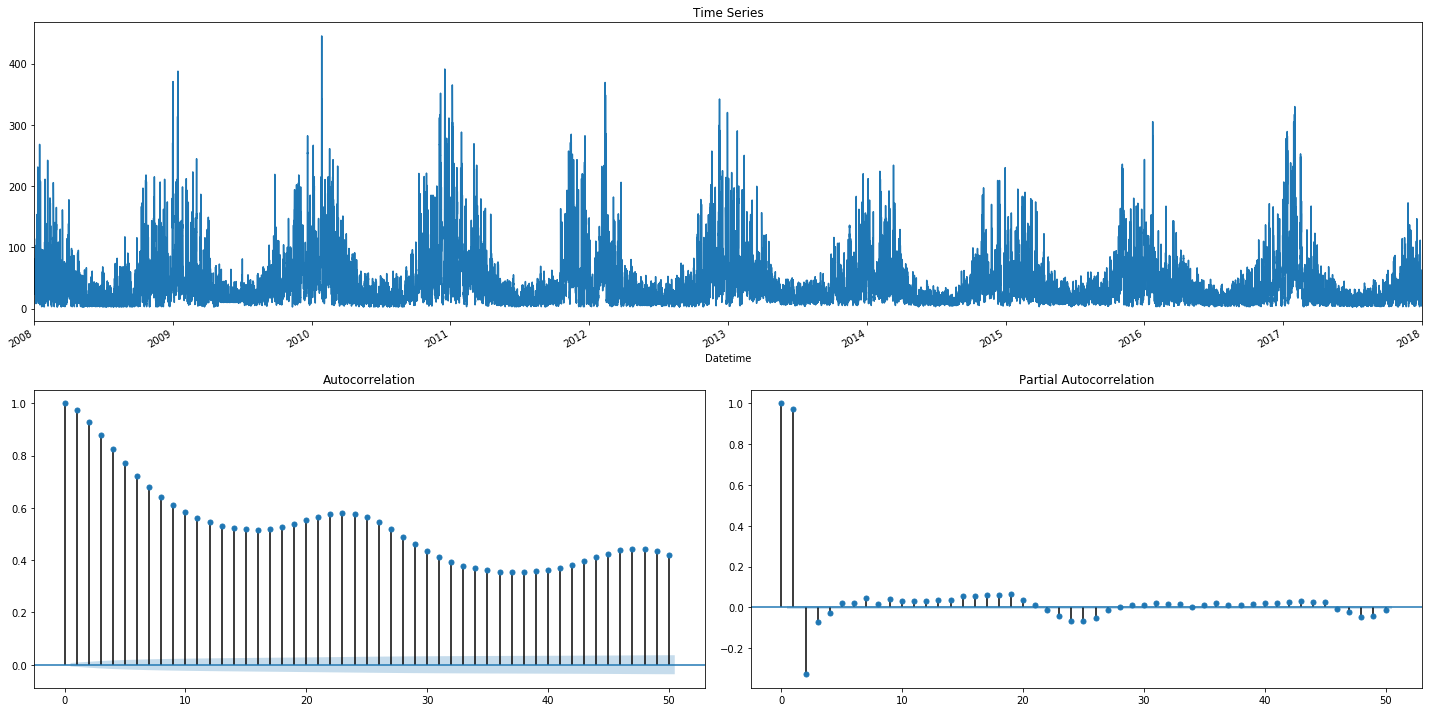

In [12]:
plot_ts_corr(df_train['pm25'])

In [13]:
%%time
# Find best parameters (grid-search)
best_results = get_best_arima_params_for_time_series(data=df_train, 
                                                     seasonal=False, 
                                                     max_param_range_p=5, 
                                                     max_param_range_d=2, 
                                                     max_param_range_q=5)

SARIMAX(0, 0, 0) - AIC:950035.119919657
SARIMAX(0, 0, 1) - AIC:843344.0396508672
SARIMAX(0, 0, 2) - AIC:772685.05307077
SARIMAX(0, 0, 3) - AIC:726435.4649042541
SARIMAX(0, 0, 4) - AIC:699267.5669061132
SARIMAX(0, 0, 5) - AIC:679220.6801305263
SARIMAX(0, 1, 0) - AIC:637526.5016885484
SARIMAX(0, 1, 1) - AIC:629960.3879021691
SARIMAX(0, 1, 2) - AIC:628846.653452479
SARIMAX(0, 1, 3) - AIC:628480.5779072419
SARIMAX(0, 1, 4) - AIC:628474.1076286844
SARIMAX(0, 1, 5) - AIC:628470.5808444964
SARIMAX(1, 0, 2) - AIC:627752.667749163
SARIMAX(1, 0, 3) - AIC:627233.671710295
SARIMAX(1, 0, 4) - AIC:627176.4310598889
SARIMAX(1, 0, 5) - AIC:627165.0028807595
SARIMAX(1, 1, 3) - AIC:626081.1199039271
SARIMAX(1, 1, 5) - AIC:625019.2327505194
SARIMAX(2, 1, 2) - AIC:624910.203481772
SARIMAX(2, 1, 3) - AIC:624873.0049011122
SARIMAX(2, 1, 4) - AIC:624854.8941542685
SARIMAX(3, 0, 3) - AIC:624793.04465309
SARIMAX(5, 0, 2) - AIC:624767.846410448
SARIMAX(5, 0, 3) - AIC:624676.504781964
Best model is ARIMA(5, 0, 3

In [ ]:
SARIMAX(0, 0, 0) - AIC:950035.119919657
SARIMAX(0, 0, 1) - AIC:843344.0396508672
SARIMAX(0, 0, 2) - AIC:772685.05307077
SARIMAX(0, 0, 3) - AIC:726435.4649042541
SARIMAX(0, 0, 4) - AIC:699267.5669061132
SARIMAX(0, 0, 5) - AIC:679220.6801305263
SARIMAX(0, 1, 0) - AIC:637526.5016885484
SARIMAX(0, 1, 1) - AIC:629960.3879021691
SARIMAX(0, 1, 2) - AIC:628846.653452479
SARIMAX(0, 1, 3) - AIC:628480.5779072419
SARIMAX(0, 1, 4) - AIC:628474.1076286844
SARIMAX(0, 1, 5) - AIC:628470.5808444964
SARIMAX(1, 0, 2) - AIC:627752.667749163
SARIMAX(1, 0, 3) - AIC:627233.671710295
SARIMAX(1, 0, 4) - AIC:627176.4310598889
SARIMAX(1, 0, 5) - AIC:627165.0028807595
SARIMAX(1, 1, 3) - AIC:626081.1199039271
SARIMAX(1, 1, 5) - AIC:625019.2327505194
SARIMAX(2, 1, 2) - AIC:624910.203481772
SARIMAX(2, 1, 3) - AIC:624873.0049011122
SARIMAX(2, 1, 4) - AIC:624854.8941542685
SARIMAX(3, 0, 3) - AIC:624793.04465309
SARIMAX(5, 0, 2) - AIC:624767.846410448
SARIMAX(5, 0, 3) - AIC:624676.504781964
Best model is ARIMA(5, 0, 3) with AIC of 624676.504781964
CPU times: user 2h 35min 14s, sys: 15min 17s, total: 2h 50min 32s
Wall time: 49min 34s

It seems, that differencing is not needed. ARIMA(5, 0, 3) model in this case is the same as ARMA(5, 3) - already assessed.

In [ ]:
%%time
# Train the model -> find best parameters
p = 5 # (AR) 
d = 0 # differencing
q = 3 # (MA)
model = SARIMAX(endog=df_train, order=(p, d, q))
model_fitted = model.fit()

In [ ]:
model_fitted

In [ ]:
# Estimated parameters
print(model_fitted.summary())

In [ ]:
# True parameters
print(f'The coefficients of the model are:\n {model_fitted.params}')

In [ ]:
print(f'The residual errors during training of the model are:\n {model_fitted.resid}')

In [ ]:
# Evaluate model quality
import statsmodels.api as sm
res = model_fitted.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show();

In [ ]:
# Evaluate model quality
model_fitted.plot_diagnostics(figsize=(20, 10))
plt.show();

ARIMA model for hourly data is the same as ARMA, no differencing componend identified by grid search. The situation looks different with daily data (see below).

In [ ]:
%%time
# Validate result on test
# Creates 365*24*24 models for hourly data, or 365*7 models for hourly data

fold_results = walk_forward_ts_model_validation2(data=df,
                                                 col_name='pm25',
                                                 model_type='ARIMA',
                                                 p=p,
                                                 d=d,
                                                 q=q,
                                                 cut_off_offset=cut_off_offset,
                                                 n_pred_points=n_pred_points,
                                                 n_folds=-1,
                                                 period=period)
print(len(fold_results))
print(fold_results[0])

### Serialize output data

In [ ]:
from joblib import dump, load

timestamp = get_datetime_identifier("%Y-%m-%d_%H-%M-%S")

path = f'results/pm25_ts_{model_name}_results_h_{timestamp}.joblib'

#dump(fold_results, path) 
fold_results = load(path)
print(len(fold_results))
print(fold_results[0])

### Calculate and visualize results

In [ ]:
%%time
# Returns a list of mean folds RMSE for n_pred_points (starting at 1 point forecast)
res = get_mean_folds_rmse_for_n_prediction_points(fold_results=fold_results, n_pred_points=n_pred_points)
res

In [ ]:
print(res)

In [ ]:
# Show forecasts for n-th point in the future
show_n_points_of_forecasts = [1, 12, 24] # for hourly data
#show_n_points_of_forecasts = [1, 3, 7] # for daily data

# Used to zoom the plots (date ranges shown in the plots)
# for hourly data
start_end_dates = [('2018-01-01', '2019-01-01'), ('2018-02-01', '2018-03-01'), ('2018-06-01', '2018-07-01')]
# for daily data
#start_end_dates = [('2018-01-01', '2019-01-01'), ('2018-02-01', '2018-04-01'), ('2018-06-01', '2018-08-01')]

# Type of plot
# 0 -> plot_observed_vs_predicted
# 1 -> plot_observed_vs_predicted_with_error
plot_types = [0, 1, 1]

# File names for plots (format png will be used, do not add .png extension)
base_file_path = f'images/pm25_obs_vs_pred_365_h_ts_{model_name}' # for hourly data
#base_file_path = f'images/pm25_obs_vs_pred_365_d_ts_{model_name}' # for daily data

In [ ]:
fold_results[0].index

In [ ]:
# We need to convert to datetime index for plotting
# https://stackoverflow.com/questions/29394730/converting-periodindex-to-datetimeindex
for i in range(0, len(fold_results)):
    if not isinstance(fold_results[i].index, pd.DatetimeIndex):
        fold_results[i].index = fold_results[i].index.to_timestamp()

In [ ]:
fold_results[0].index

In [ ]:
visualize_results(show_n_points_of_forecasts=show_n_points_of_forecasts,
                   start_end_dates=start_end_dates,
                   plot_types=plot_types,
                   base_file_path=base_file_path,
                   fold_results=fold_results, 
                   n_pred_points=n_pred_points, 
                   cut_off_offset=cut_off_offset, 
                   model_name=model_name,
                timestamp=timestamp)

---
<a id='data_d'></a>

## Load daily data

In [8]:
dfd = get_pm25_data_for_modelling('ts', 'd')
dfd.head()

common.py | 42 | get_pm25_data_for_modelling | 10-Jun-20 19:22:04 | INFO: Dataframe loaded: /Users/ksatola/Documents/git/air-pollution/agh/data/dfpm25_2008-2018_daily.hdf
common.py | 43 | get_pm25_data_for_modelling | 10-Jun-20 19:22:04 | INFO: Dataframe size: (4019, 1)


,pm25
Datetime,
2008-01-01,53.586957
2008-01-02,30.958333
2008-01-03,46.104167
2008-01-04,42.979167
2008-01-05,57.312500


In [9]:
df = dfd.copy()

In [10]:
# Define first past/future cutoff point in time offset (1 year of data)
#cut_off_offset = 365*24 # for hourly data
cut_off_offset = 365 # for daily data

# Predict for X points
#n_pred_points = 24 # for hourly data
n_pred_points = 7 # for daily data

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
#period = 'H' # for hourly data
period = 'D' # for daily data

### Train test split

In [11]:
# Create train / test datasets (with the offset of cut_off_offset datapoints from the end)
# period=None because we need index to be DatetimeIndex not PeriodIndex for SARIMAX
df_train, df_test = split_df_for_ts_modelling_offset(data=df, cut_off_offset=cut_off_offset, period=None)

common.py | 159 | split_df_for_ts_modelling_offset | 10-Jun-20 19:22:09 | INFO: Observations: 4019
common.py | 160 | split_df_for_ts_modelling_offset | 10-Jun-20 19:22:09 | INFO: Training Observations: 3653
common.py | 161 | split_df_for_ts_modelling_offset | 10-Jun-20 19:22:09 | INFO: Testing Observations: 365
common.py | 163 | split_df_for_ts_modelling_offset | 10-Jun-20 19:22:09 | INFO: (4019, 1), (3653, 1), (365, 1), 4018


---
<a id='model_d'></a>

## Modelling (train, predict/validate)

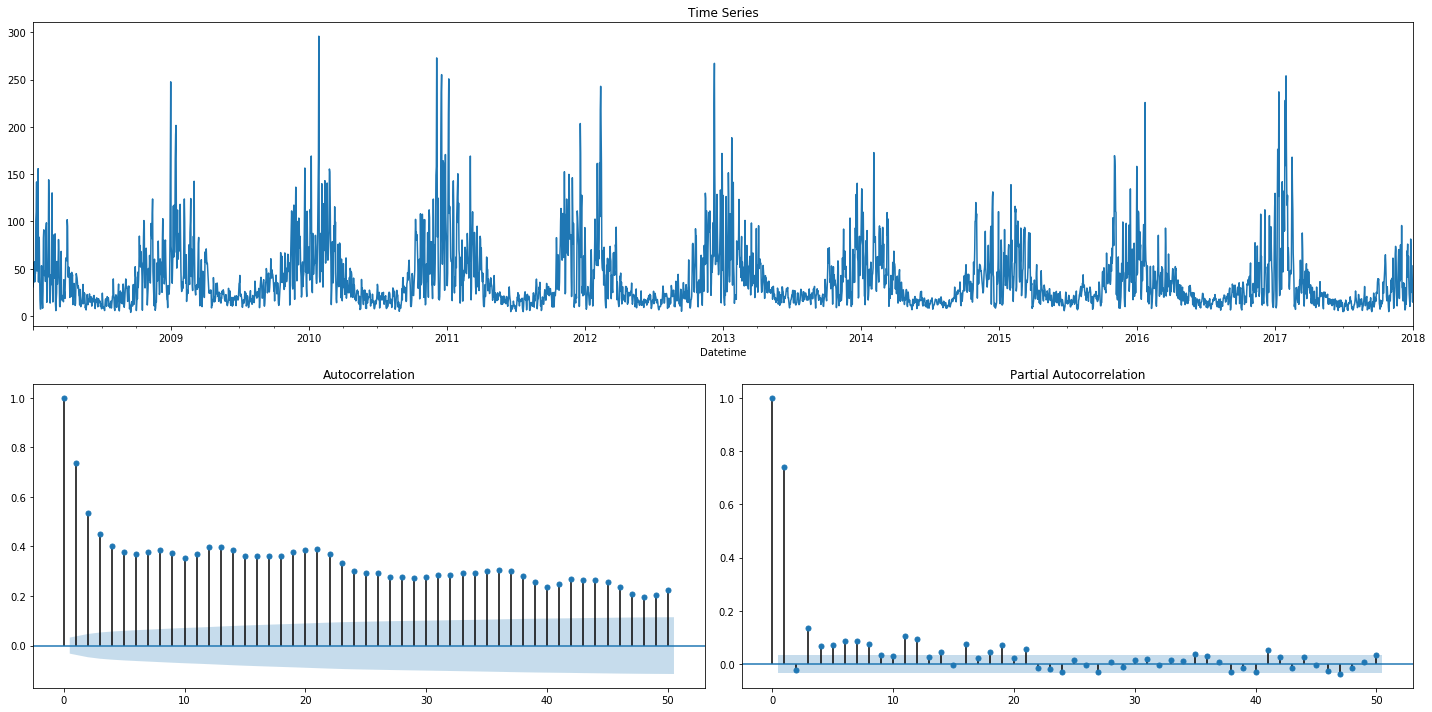

In [12]:
plot_ts_corr(df_train['pm25'])

In [20]:
%%time
# Find best parameters (grid-search)
best_results = get_best_arima_params_for_time_series(data=df_train, 
                                                     seasonal=False, 
                                                     max_param_range_p=5, 
                                                     max_param_range_d=2, 
                                                     max_param_range_q=5)

SARIMAX(0, 0, 0) - AIC:38983.00813026588
SARIMAX(0, 0, 1) - AIC:36059.690659735024
SARIMAX(0, 0, 2) - AIC:34918.45008233713
SARIMAX(0, 0, 3) - AIC:34409.81571434598
SARIMAX(0, 0, 4) - AIC:34096.090358520945
SARIMAX(0, 0, 5) - AIC:33892.384328226864
SARIMAX(0, 1, 0) - AIC:33539.96628828756
SARIMAX(0, 1, 1) - AIC:33449.44954425901
SARIMAX(0, 1, 2) - AIC:32931.60308460837
SARIMAX(0, 1, 3) - AIC:32816.55925132237
SARIMAX(0, 1, 4) - AIC:32800.81192666262
SARIMAX(0, 1, 5) - AIC:32797.1756013764
SARIMAX(1, 1, 2) - AIC:32795.455033729144
SARIMAX(2, 1, 5) - AIC:32785.685117122935
SARIMAX(3, 1, 5) - AIC:32784.56482396528
SARIMAX(4, 1, 5) - AIC:32781.63782767311
Best model is ARIMA(4, 1, 5) with AIC of 32781.63782767311
CPU times: user 11min 17s, sys: 1min 31s, total: 12min 48s
Wall time: 3min 16s


In [ ]:
SARIMAX(0, 0, 0) - AIC:38983.00813026588
SARIMAX(0, 0, 1) - AIC:36059.690659735024
SARIMAX(0, 0, 2) - AIC:34918.45008233713
SARIMAX(0, 0, 3) - AIC:34409.81571434598
SARIMAX(0, 0, 4) - AIC:34096.090358520945
SARIMAX(0, 0, 5) - AIC:33892.384328226864
SARIMAX(0, 1, 0) - AIC:33539.96628828756
SARIMAX(0, 1, 1) - AIC:33449.44954425901
SARIMAX(0, 1, 2) - AIC:32931.60308460837
SARIMAX(0, 1, 3) - AIC:32816.55925132237
SARIMAX(0, 1, 4) - AIC:32800.81192666262
SARIMAX(0, 1, 5) - AIC:32797.1756013764
SARIMAX(1, 1, 2) - AIC:32795.455033729144
SARIMAX(2, 1, 5) - AIC:32785.685117122935
SARIMAX(3, 1, 5) - AIC:32784.56482396528
SARIMAX(4, 1, 5) - AIC:32781.63782767311
Best model is ARIMA(4, 1, 5) with AIC of 32781.63782767311
CPU times: user 11min 17s, sys: 1min 31s, total: 12min 48s
Wall time: 3min 16s

In [54]:
%%time
# Train the model -> find best parameters
p = 4 # (AR) 
d = 1 # differencing
q = 5 # (MA)
model = SARIMAX(endog=df_train['pm25'], order=(p, d, q))
model_fitted = model.fit()

CPU times: user 9.05 s, sys: 1.06 s, total: 10.1 s
Wall time: 2.52 s


In [55]:
model_fitted

In [56]:
# Estimated parameters
print(model_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                   pm25   No. Observations:                 3653
Model:               SARIMAX(4, 1, 5)   Log Likelihood              -16380.819
Date:                Wed, 10 Jun 2020   AIC                          32781.638
Time:                        20:13:48   BIC                          32843.668
Sample:                    01-02-2008   HQIC                         32803.728
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1938      0.378      0.513      0.608      -0.547       0.934
ar.L2         -0.5157      0.346     -1.490      0.136      -1.194       0.163
ar.L3         -0.4200      0.432     -0.972      0.3

In [57]:
# True parameters
print(f'The coefficients of the model are:\n {model_fitted.params}')

The coefficients of the model are:
 ar.L1       0.193800
ar.L2      -0.515660
ar.L3      -0.420042
ar.L4       0.222948
ma.L1      -0.490835
ma.L2       0.233813
ma.L3       0.212947
ma.L4      -0.560303
ma.L5      -0.191942
sigma2    461.138689
dtype: float64


In [58]:
print(f'The residual errors during training of the model are:\n {model_fitted.resid}')

The residual errors during training of the model are:
 Datetime
2008-01-02    30.958333
2008-01-03    15.147851
2008-01-04    -1.387449
2008-01-05    17.631205
2008-01-06   -17.362047
                ...    
2017-12-28   -19.228414
2017-12-29    -7.630397
2017-12-30     3.542937
2017-12-31   -18.037013
2018-01-01    33.731246
Freq: D, Length: 3653, dtype: float64


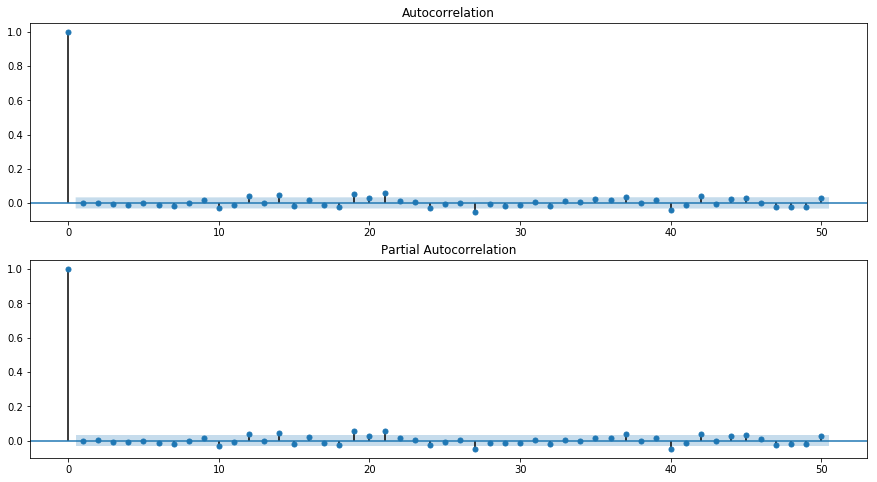

In [59]:
# Evaluate model quality
import statsmodels.api as sm
res = model_fitted.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show();

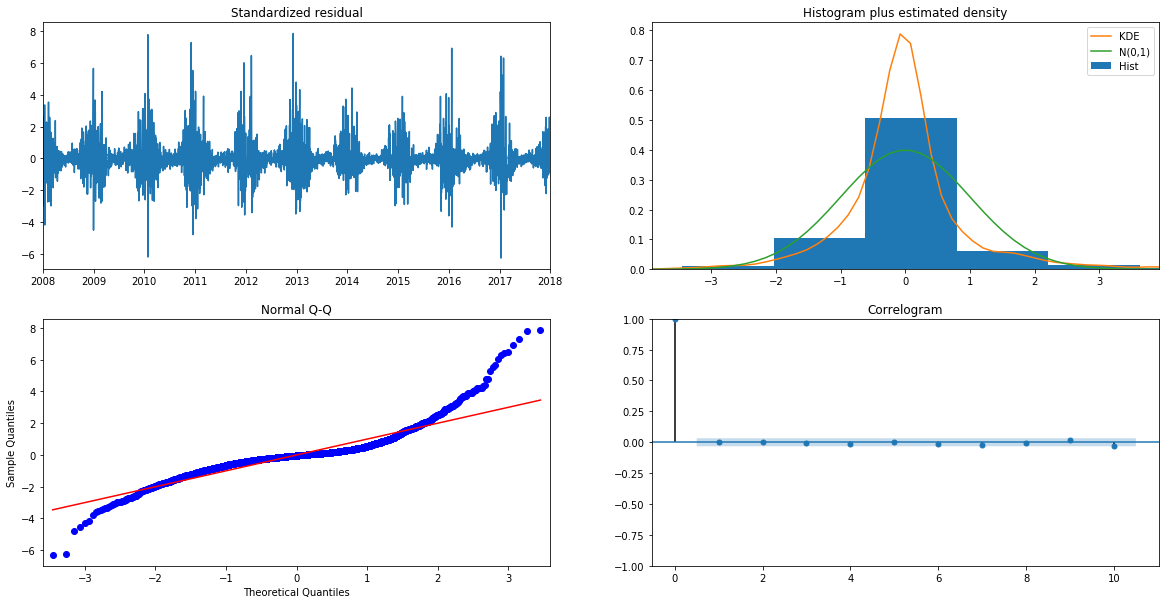

In [60]:
# Evaluate model quality
model_fitted.plot_diagnostics(figsize=(20, 10))
plt.show();

In [86]:
df[1, 'pm25']

KeyError: (1, 'pm25')

In [79]:
%%time
# Validate result on test
# Creates 365*24*24 models for hourly data, or 365*7 models for hourly data

fold_results = walk_forward_ts_model_validation2(data=df,
                                                 col_name='pm25',
                                                 model_type='ARIMA',
                                                 p=1,#p,
                                                 d=1,#d,
                                                 q=1,#q,
                                                 cut_off_offset=50,#cut_off_offset,
                                                 n_pred_points=n_pred_points,
                                                 n_folds=-1,
                                                 period=period)
print(len(fold_results))
print(fold_results[0])

validation.py | 78 | walk_forward_ts_model_validation2 | 11-Jun-20 00:33:00 | INFO: (1, 1, 1)
validation.py | 86 | walk_forward_ts_model_validation2 | 11-Jun-20 00:33:00 | INFO: ARIMA model validation started


Started fold 000000/000050 - 2020-06-11_00-33-00


ValueError: shape mismatch: value array of shape (1,3969) could not be broadcast to indexing result of shape (1,1)

In [ ]:
validation.py | 78 | walk_forward_ts_model_validation2 | 10-Jun-20 20:14:06 | INFO: (4, 1, 5)
validation.py | 86 | walk_forward_ts_model_validation2 | 10-Jun-20 20:14:06 | INFO: ARIMA model validation started
Started fold 000000/000365 - 2020-06-10_20-14-06
Started fold 000010/000365 - 2020-06-10_20-18-51
Started fold 000020/000365 - 2020-06-10_20-23-20
Started fold 000030/000365 - 2020-06-10_20-28-34
Started fold 000040/000365 - 2020-06-10_20-34-06
Started fold 000050/000365 - 2020-06-10_20-39-21
Started fold 000060/000365 - 2020-06-10_20-44-15
Started fold 000070/000365 - 2020-06-10_20-49-20
Started fold 000080/000365 - 2020-06-10_20-53-48
Started fold 000090/000365 - 2020-06-10_20-59-06
Started fold 000100/000365 - 2020-06-10_21-04-04
Started fold 000110/000365 - 2020-06-10_21-08-39
Started fold 000120/000365 - 2020-06-10_21-13-34
Started fold 000130/000365 - 2020-06-10_21-18-07
Started fold 000140/000365 - 2020-06-10_21-22-13
Started fold 000150/000365 - 2020-06-10_21-26-37
Started fold 000160/000365 - 2020-06-10_21-31-08
Started fold 000170/000365 - 2020-06-10_21-35-44
Started fold 000180/000365 - 2020-06-10_21-40-38
Started fold 000190/000365 - 2020-06-10_21-45-25
Started fold 000200/000365 - 2020-06-10_21-50-07
Started fold 000210/000365 - 2020-06-10_21-54-23
Started fold 000220/000365 - 2020-06-10_21-58-56
Started fold 000230/000365 - 2020-06-10_22-03-19
Started fold 000240/000365 - 2020-06-10_22-08-08
Started fold 000250/000365 - 2020-06-10_22-13-06
Started fold 000260/000365 - 2020-06-10_22-17-35
Started fold 000270/000365 - 2020-06-10_22-22-34
Started fold 000280/000365 - 2020-06-10_22-27-27
Started fold 000290/000365 - 2020-06-10_22-32-45
Started fold 000300/000365 - 2020-06-10_22-37-41
Started fold 000310/000365 - 2020-06-10_22-42-30
Started fold 000320/000365 - 2020-06-10_22-48-01
Started fold 000330/000365 - 2020-06-10_22-53-29
Started fold 000340/000365 - 2020-06-10_22-58-29
Started fold 000350/000365 - 2020-06-10_23-04-09
Started fold 000360/000365 - 2020-06-10_23-09-21
365
             observed     predicted         error     abs_error
Datetime                                                       
2018-01-02  67.991848  3.075359e+02  2.395441e+02  2.395441e+02
2018-01-03  16.026950  1.184571e+04  1.182969e+04  1.182969e+04
2018-01-04  14.590020 -3.438611e+04  3.440070e+04  3.440070e+04
2018-01-05  22.094854  2.781667e+06  2.781645e+06  2.781645e+06
2018-01-06  62.504217  6.274784e+08  6.274783e+08  6.274783e+08
2018-01-07  43.929804  1.441689e+13  1.441689e+13  1.441689e+13
2018-01-08  22.088192 -1.158673e+18  1.158673e+18  1.158673e+18
CPU times: user 3h 5min 58s, sys: 2min 19s, total: 3h 8min 17s
Wall time: 2h 56min 11s

---------------------------------
ERROR, also when using order(4, 1, 5):
Added initialization='approximate_diffuse' param do SARIMAX() function in fit_model() as per:
https://stackoverflow.com/questions/54136280/sarimax-python-np-linalg-linalg-linalgerror-lu-decomposition-error

validation.py | 78 | walk_forward_ts_model_validation2 | 10-Jun-20 19:43:46 | INFO: (1, 1, 1)
validation.py | 86 | walk_forward_ts_model_validation2 | 10-Jun-20 19:43:46 | INFO: ARIMA model validation started
Started fold 000000/000365 - 2020-06-10_19-43-46
Started fold 000010/000365 - 2020-06-10_19-44-04
Started fold 000020/000365 - 2020-06-10_19-44-22
Started fold 000030/000365 - 2020-06-10_19-44-39
Started fold 000040/000365 - 2020-06-10_19-44-57
Started fold 000050/000365 - 2020-06-10_19-45-17
Started fold 000060/000365 - 2020-06-10_19-45-36
Started fold 000070/000365 - 2020-06-10_19-45-54
Started fold 000080/000365 - 2020-06-10_19-46-15
Started fold 000090/000365 - 2020-06-10_19-46-30
Started fold 000100/000365 - 2020-06-10_19-46-46
Started fold 000110/000365 - 2020-06-10_19-47-02
Started fold 000120/000365 - 2020-06-10_19-47-23
Started fold 000130/000365 - 2020-06-10_19-47-41
Started fold 000140/000365 - 2020-06-10_19-48-01
Started fold 000150/000365 - 2020-06-10_19-48-19
Started fold 000160/000365 - 2020-06-10_19-48-39
Started fold 000170/000365 - 2020-06-10_19-48-59
Started fold 000180/000365 - 2020-06-10_19-49-17
---------------------------------------------------------------------------
LinAlgError                               Traceback (most recent call last)
<timed exec> in <module>

~/Documents/git/air-pollution/src/measure/validation.py in walk_forward_ts_model_validation2(data, col_name, model_type, p, d, q, cut_off_offset, n_pred_points, n_folds, period)
    118             # Fit a model with updated historical data (each time we add a predicted value to the end of history)
    119             model = SARIMAX(endog=history, order=(p, d, q))
--> 120             model_fitted = fit_model(endog=history, p=p, d=d, q=q)
    121 
    122             # Get prediction for t+1 lag

~/Documents/git/air-pollution/src/model/arima.py in fit_model(endog, p, d, q)
     17     """
     18     model = SARIMAX(endog=endog, order=(p, d, q))
---> 19     model_fitted = model.fit()
     20     return model_fitted
     21 

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py in fit(self, start_params, transformed, includes_fixed, cov_type, cov_kwds, method, maxiter, full_output, disp, callback, return_params, optim_score, optim_complex_step, optim_hessian, flags, low_memory, **kwargs)
    657                                                full_output=full_output,
    658                                                disp=disp, callback=callback,
--> 659                                                skip_hessian=True, **kwargs)
    660 
    661         # Just return the fitted parameters if requested

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py in fit(self, start_params, method, maxiter, full_output, disp, fargs, callback, retall, skip_hessian, **kwargs)
    524                                                        callback=callback,
    525                                                        retall=retall,
--> 526                                                        full_output=full_output)
    527 
    528         # NOTE: this is for fit_regularized and should be generalized

/usr/local/lib/python3.7/site-packages/statsmodels/base/optimizer.py in _fit(self, objective, gradient, start_params, fargs, kwargs, hessian, method, maxiter, full_output, disp, callback, retall)
    216                             disp=disp, maxiter=maxiter, callback=callback,
    217                             retall=retall, full_output=full_output,
--> 218                             hess=hessian)
    219 
    220         optim_settings = {'optimizer': method, 'start_params': start_params,

/usr/local/lib/python3.7/site-packages/statsmodels/base/optimizer.py in _fit_lbfgs(f, score, start_params, fargs, kwargs, disp, maxiter, callback, retall, full_output, hess)
    438                                      callback=callback, args=fargs,
    439                                      bounds=bounds, disp=disp,
--> 440                                      **extra_kwargs)
    441 
    442     if full_output:

/usr/local/lib/python3.7/site-packages/scipy/optimize/lbfgsb.py in fmin_l_bfgs_b(func, x0, fprime, args, approx_grad, bounds, m, factr, pgtol, epsilon, iprint, maxfun, maxiter, disp, callback, maxls)
    197 
    198     res = _minimize_lbfgsb(fun, x0, args=args, jac=jac, bounds=bounds,
--> 199                            **opts)
    200     d = {'grad': res['jac'],
    201          'task': res['message'],

/usr/local/lib/python3.7/site-packages/scipy/optimize/lbfgsb.py in _minimize_lbfgsb(fun, x0, args, jac, bounds, disp, maxcor, ftol, gtol, eps, maxfun, maxiter, iprint, callback, maxls, **unknown_options)
    343             # until the completion of the current minimization iteration.
    344             # Overwrite f and g:
--> 345             f, g = func_and_grad(x)
    346         elif task_str.startswith(b'NEW_X'):
    347             # new iteration

/usr/local/lib/python3.7/site-packages/scipy/optimize/lbfgsb.py in func_and_grad(x)
    288     if jac is None:
    289         def func_and_grad(x):
--> 290             f = fun(x, *args)
    291             g = _approx_fprime_helper(x, fun, epsilon, args=args, f0=f)
    292             return f, g

/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py in function_wrapper(*wrapper_args)
    325     def function_wrapper(*wrapper_args):
    326         ncalls[0] += 1
--> 327         return function(*(wrapper_args + args))
    328 
    329     return ncalls, function_wrapper

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py in f(params, *args)
    498 
    499         def f(params, *args):
--> 500             return -self.loglike(params, *args) / nobs
    501 
    502         if method == 'newton':

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py in loglike(self, params, *args, **kwargs)
    887             kwargs['inversion_method'] = INVERT_UNIVARIATE | SOLVE_LU
    888 
--> 889         loglike = self.ssm.loglike(complex_step=complex_step, **kwargs)
    890 
    891         # Koopman, Shephard, and Doornik recommend maximizing the average

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py in loglike(self, **kwargs)
    975         kwargs.setdefault('conserve_memory',
    976                           MEMORY_CONSERVE ^ MEMORY_NO_LIKELIHOOD)
--> 977         kfilter = self._filter(**kwargs)
    978         loglikelihood_burn = kwargs.get('loglikelihood_burn',
    979                                         self.loglikelihood_burn)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py in _filter(self, filter_method, inversion_method, stability_method, conserve_memory, filter_timing, tolerance, loglikelihood_burn, complex_step)
    895 
    896         # Initialize the state
--> 897         self._initialize_state(prefix=prefix, complex_step=complex_step)
    898 
    899         # Run the filter

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py in _initialize_state(self, prefix, complex_step)
    948                 raise RuntimeError('Initialization is incomplete.')
    949             self._statespaces[prefix].initialize(self.initialization,
--> 950                                                  complex_step=complex_step)
    951         else:
    952             raise RuntimeError('Statespace model not initialized.')

statsmodels/tsa/statespace/_representation.pyx in statsmodels.tsa.statespace._representation.dStatespace.initialize()

statsmodels/tsa/statespace/_representation.pyx in statsmodels.tsa.statespace._representation.dStatespace.initialize()

statsmodels/tsa/statespace/_initialization.pyx in statsmodels.tsa.statespace._initialization.dInitialization.initialize()

statsmodels/tsa/statespace/_initialization.pyx in statsmodels.tsa.statespace._initialization.dInitialization.initialize_stationary_stationary_cov()

statsmodels/tsa/statespace/_tools.pyx in statsmodels.tsa.statespace._tools._dsolve_discrete_lyapunov()

LinAlgError: LU decomposition error.

### Serialize output data

In [62]:
from joblib import dump, load

timestamp = get_datetime_identifier("%Y-%m-%d_%H-%M-%S")

path = f'results/pm25_ts_{model_name}_results_d_{timestamp}.joblib'

dump(fold_results, path) 
fold_results = load(path)
print(len(fold_results))
print(fold_results[0])

365
             observed     predicted         error     abs_error
Datetime                                                       
2018-01-02  67.991848  3.075359e+02  2.395441e+02  2.395441e+02
2018-01-03  16.026950  1.184571e+04  1.182969e+04  1.182969e+04
2018-01-04  14.590020 -3.438611e+04  3.440070e+04  3.440070e+04
2018-01-05  22.094854  2.781667e+06  2.781645e+06  2.781645e+06
2018-01-06  62.504217  6.274784e+08  6.274783e+08  6.274783e+08
2018-01-07  43.929804  1.441689e+13  1.441689e+13  1.441689e+13
2018-01-08  22.088192 -1.158673e+18  1.158673e+18  1.158673e+18


### Calculate and visualize results

In [63]:
%%time
# Returns a list of mean folds RMSE for n_pred_points (starting at 1 point forecast)
res = get_mean_folds_rmse_for_n_prediction_points(fold_results=fold_results, n_pred_points=n_pred_points)
res

CPU times: user 2.32 s, sys: 10.8 ms, total: 2.33 s
Wall time: 2.33 s


[775.957625698324,
 48833.27387206704,
 802904651203.7188,
 45456643990537.44,
 1.4134478601702074e+17,
 1.8414676023727583e+28,
 1.0581914995691296e+43]

In [64]:
print(res)

[775.957625698324, 48833.27387206704, 802904651203.7188, 45456643990537.44, 1.4134478601702074e+17, 1.8414676023727583e+28, 1.0581914995691296e+43]


[775.957625698324, 48833.27387206704, 802904651203.7188, 45456643990537.44, 1.4134478601702074e+17, 1.8414676023727583e+28, 1.0581914995691296e+43]

In [65]:
# Show forecasts for n-th point in the future
#show_n_points_of_forecasts = [1, 12, 24] # for hourly data
show_n_points_of_forecasts = [1, 3, 7] # for daily data

# Used to zoom the plots (date ranges shown in the plots)
# for hourly data
#start_end_dates = [('2018-01-01', '2019-01-01'), ('2018-02-01', '2018-03-01'), ('2018-06-01', '2019-07-01')]
# for daily data
start_end_dates = [('2018-01-01', '2019-01-01'), ('2018-02-01', '2018-04-01'), ('2018-06-01', '2019-08-01')]

# Type of plot
# 0 -> plot_observed_vs_predicted
# 1 -> plot_observed_vs_predicted_with_error
plot_types = [0, 1, 1]

# File names for plots (format png will be used, do not add .png extension)
#base_file_path = f'images/pm25_obs_vs_pred_365_h_ts_{model_name}' # for hourly data
base_file_path = f'images/pm25_obs_vs_pred_365_d_ts_{model_name}' # for daily data

In [66]:
fold_results[0].index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-06', '2018-01-07', '2018-01-08'],
              dtype='datetime64[ns]', name='Datetime', freq='D')

In [67]:
# We need to convert to datetime index for plotting
# https://stackoverflow.com/questions/29394730/converting-periodindex-to-datetimeindex
for i in range(0, len(fold_results)):
    if not isinstance(fold_results[i].index, pd.DatetimeIndex):
        fold_results[i].index = fold_results[i].index.to_timestamp()

In [68]:
fold_results[0].index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-06', '2018-01-07', '2018-01-08'],
              dtype='datetime64[ns]', name='Datetime', freq='D')

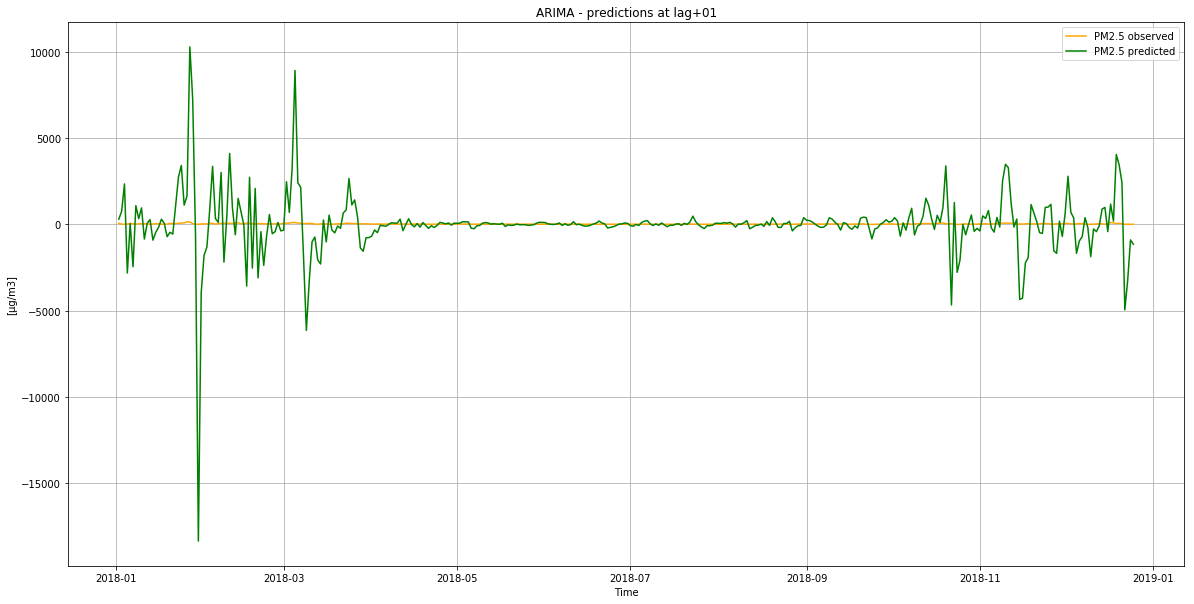

results.py | 92 | visualize_results | 10-Jun-20 23:14:01 | INFO: images/pm25_obs_vs_pred_365_d_ts_ARIMA_01_lag-01_2020-06-10_23-13-21.png


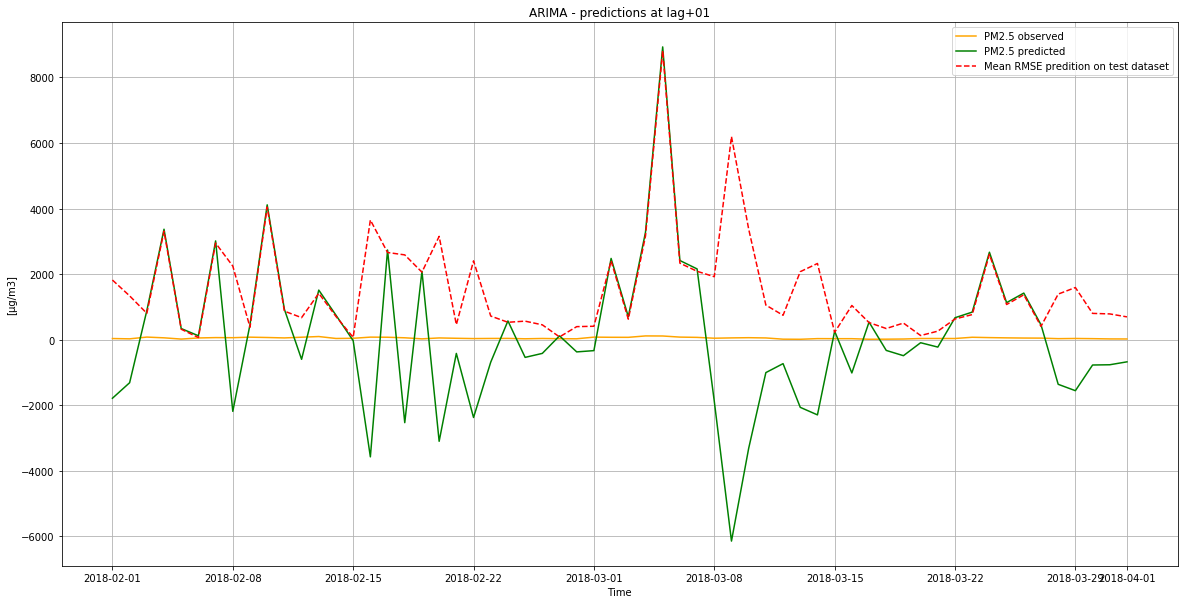

results.py | 92 | visualize_results | 10-Jun-20 23:14:02 | INFO: images/pm25_obs_vs_pred_365_d_ts_ARIMA_01_lag-03_2020-06-10_23-13-21.png


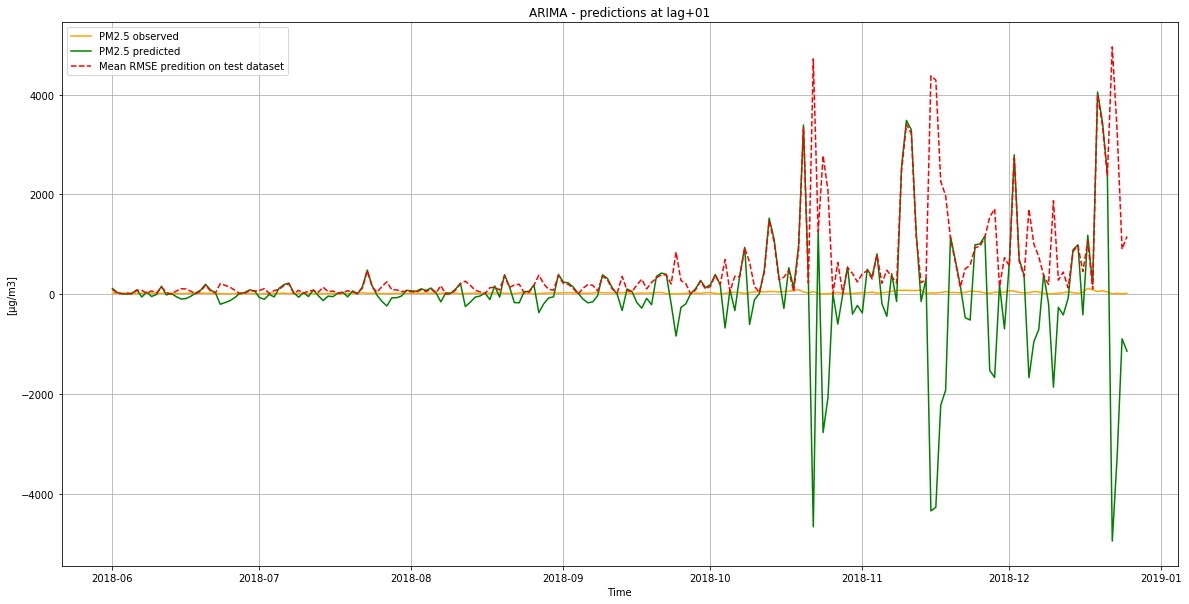

results.py | 92 | visualize_results | 10-Jun-20 23:14:02 | INFO: images/pm25_obs_vs_pred_365_d_ts_ARIMA_01_lag-07_2020-06-10_23-13-21.png


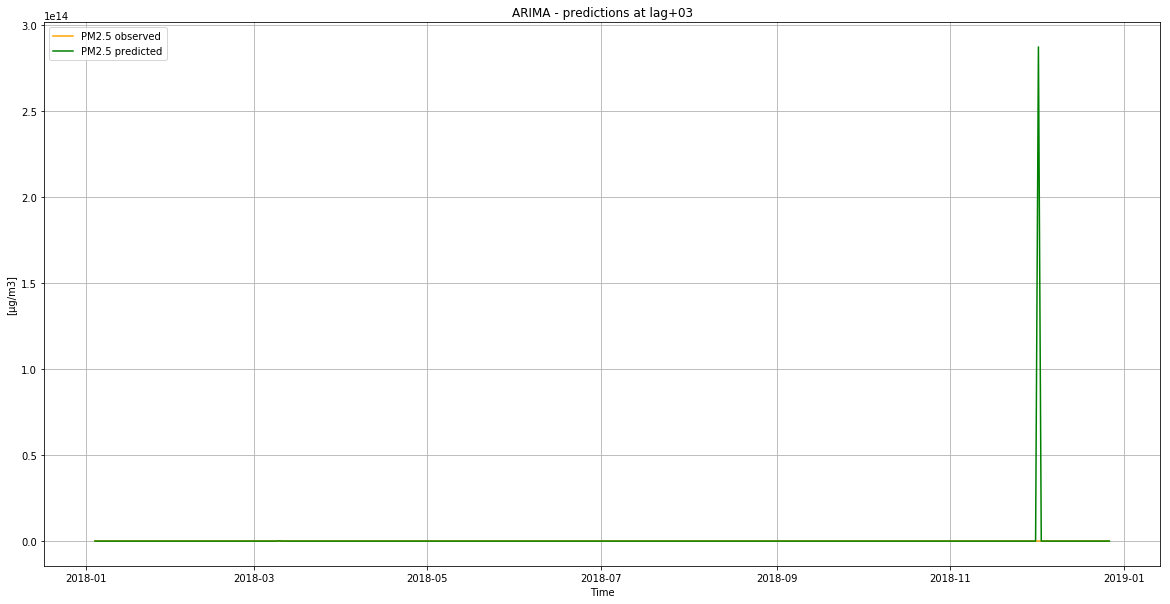

results.py | 92 | visualize_results | 10-Jun-20 23:14:03 | INFO: images/pm25_obs_vs_pred_365_d_ts_ARIMA_02_lag-01_2020-06-10_23-13-21.png


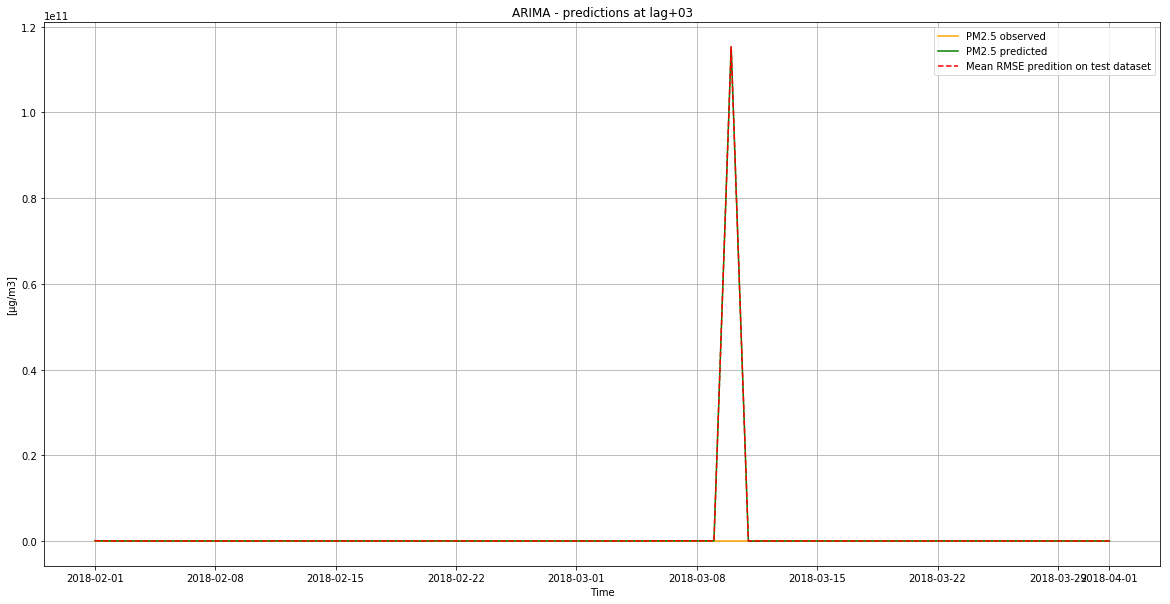

results.py | 92 | visualize_results | 10-Jun-20 23:14:04 | INFO: images/pm25_obs_vs_pred_365_d_ts_ARIMA_02_lag-03_2020-06-10_23-13-21.png


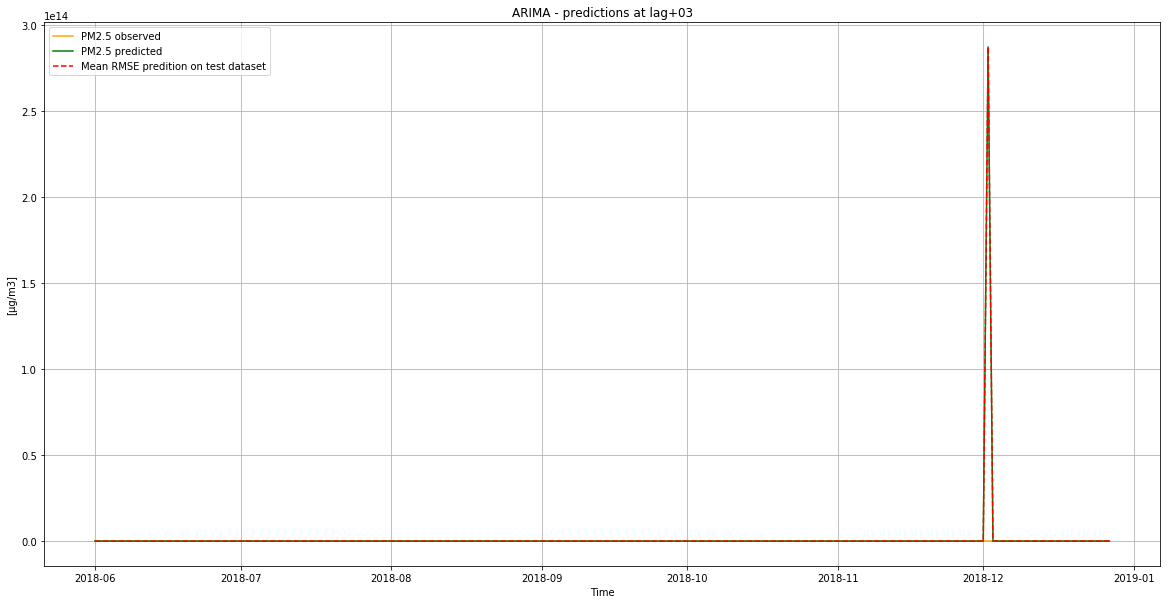

results.py | 92 | visualize_results | 10-Jun-20 23:14:05 | INFO: images/pm25_obs_vs_pred_365_d_ts_ARIMA_02_lag-07_2020-06-10_23-13-21.png


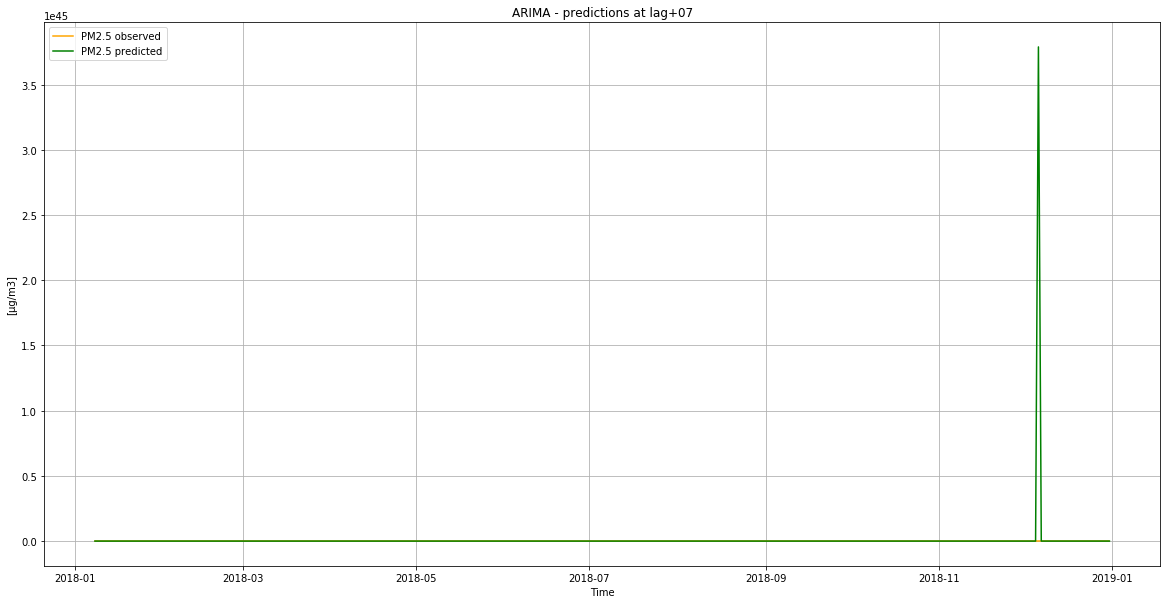

results.py | 92 | visualize_results | 10-Jun-20 23:14:06 | INFO: images/pm25_obs_vs_pred_365_d_ts_ARIMA_03_lag-01_2020-06-10_23-13-21.png


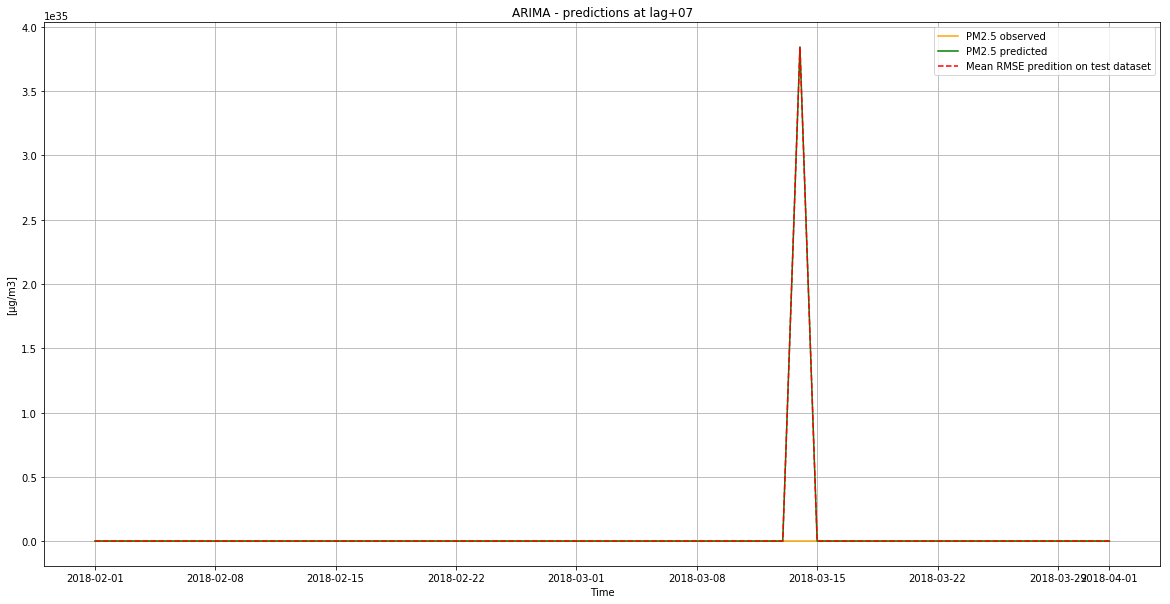

results.py | 92 | visualize_results | 10-Jun-20 23:14:06 | INFO: images/pm25_obs_vs_pred_365_d_ts_ARIMA_03_lag-03_2020-06-10_23-13-21.png


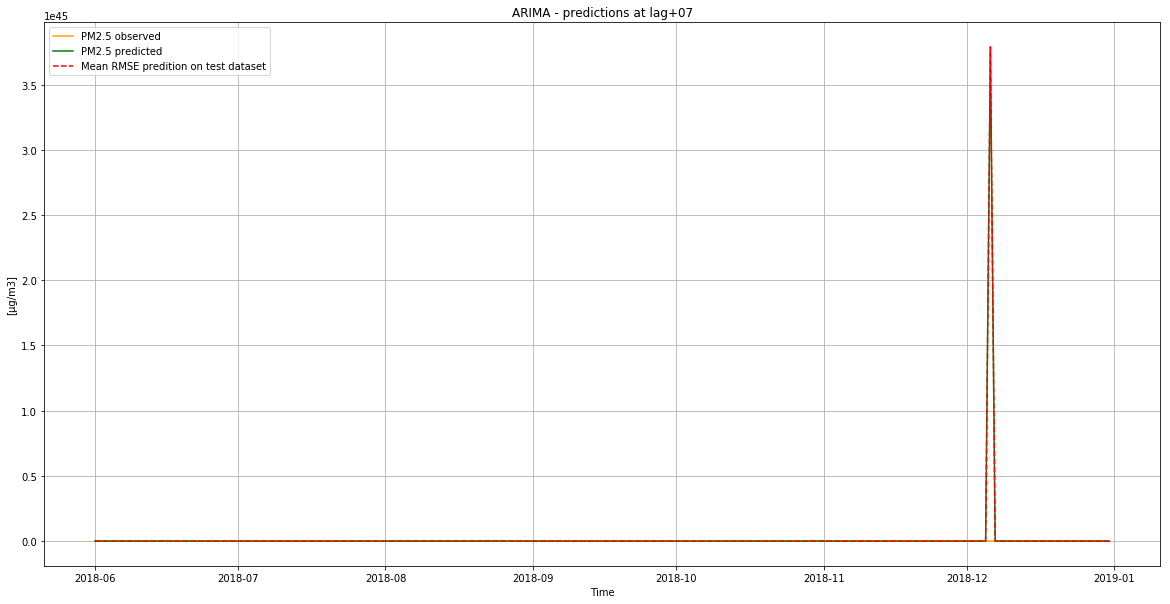

results.py | 92 | visualize_results | 10-Jun-20 23:14:07 | INFO: images/pm25_obs_vs_pred_365_d_ts_ARIMA_03_lag-07_2020-06-10_23-13-21.png


In [69]:
visualize_results(show_n_points_of_forecasts=show_n_points_of_forecasts,
                   start_end_dates=start_end_dates,
                   plot_types=plot_types,
                   base_file_path=base_file_path,
                   fold_results=fold_results, 
                   n_pred_points=n_pred_points, 
                   cut_off_offset=cut_off_offset, 
                   model_name=model_name,
                timestamp=timestamp)